<a href="https://colab.research.google.com/github/YoTaSo/datascience/blob/main/rl/qlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import libraries

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/RLD/TME3'
os.chdir(root_path)
import matplotlib
#matplotlib.use("TkAgg")
import gym
import gridworld
from gym import wrappers, logger
import numpy as np
import copy
import matplotlib.pyplot as plt

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# learning agent classes

In [ ]:
class QlearningAgent(object):
  def __init__ (self,states,actions,lr=0.01,gamma=1,eps=0.3):
    self.states=states
    self.actions=np.arange(actions.n)
    self.st=""
    self.lr=lr
    self.eps=eps
    self.gamma=gamma
    #self.winstate=list(states.keys())[5]
    #self.losestate=list(states.keys())[1]

    #initilize Q-table
    self.qtable={}
    for s in self.states:
      '''
      if s==self.winstate:
        self.qtable[s]=dict(zip(self.actions,np.ones(len(self.actions))))
      elif s==self.losestate:
        self.qtable[s]=dict(zip(self.actions,-np.ones(len(self.actions))))
      else:
      '''
      self.qtable[s]=dict(zip(self.actions,np.zeros(len(self.actions))))
    
  def epsGreedpolicy(self,obs):
      u=np.random.rand(1)[0]
      dd=self.qtable[obs]
      if u>self.eps:
        a=max(dd, key=dd.get)
      else:
        a=np.random.choice(list(dd.keys()))
      
      return a
      
      
  def updateQvals(self,st0,st1,action,r,done):
      st0=str(st0.tolist())
      st1=str(st1.tolist())
      #\if not done:
      qst1=self.qtable[st1]
      qst1a=max(list(qst1.values()))
      qst0a=self.qtable[st0][action]
      self.qtable[st0][action]=qst0a+self.lr*(r+self.gamma*qst1a-qst0a)

  def act(self,obs):
      obs=str(obs.tolist())
      action=self.epsGreedpolicy(obs)
      return action

In [ ]:
class SARSAAgent(object):
  def __init__ (self,states,actions,lr=0.01,gamma=1,eps=0.3):
    self.states=states
    self.actions=np.arange(actions.n)
    self.st=""
    self.lr=lr
    self.eps=eps
    self.gamma=gamma
    #self.winstate=list(states.keys())[5]
    #self.losestate=list(states.keys())[1]

    #initilize Q-table
    self.qtable={}
    for s in self.states:
      '''
      if s==self.winstate:
        self.qtable[s]=dict(zip(self.actions,np.ones(len(self.actions))))
      elif s==self.losestate:
        self.qtable[s]=dict(zip(self.actions,-np.ones(len(self.actions))))
      else:
      '''
      self.qtable[s]=dict(zip(self.actions,np.zeros(len(self.actions))))
  
  def epsGreedpolicy(self,obs):
      u=np.random.rand(1)[0]
      dd=self.qtable[obs]
      if u>self.eps:
        a=max(dd, key=dd.get)
      else:
        a=np.random.choice(list(dd.keys()))
      return a
      
      
  def updateQvals(self,st0,st1,action1,action2,r,done):
      st0=str(st0.tolist())
      st1=str(st1.tolist())

      #if not done:
      qst0a=self.qtable[st0][action1]
      qst1a=self.qtable[st1][action2]
      self.qtable[st0][action1]=qst0a+self.lr*(r+self.gamma*qst1a-qst0a)

  def act(self,obs):
      obs=str(obs.tolist())
      action=self.epsGreedpolicy(obs)
      return action

In [ ]:
class DynaQAgent(object):
  def __init__ (self,states,actions,terminal_states,lr=0.01,gamma=1,eps=0.3,k=10,alphaUpdate=.01):
    self.states=states
    self.actions=np.arange(actions.n)
    self.st=""
    self.lr=lr
    self.eps=eps
    self.gamma=gamma
    #self.winstate=list(states.keys())[5]
    #self.losestate=list(states.keys())[1]
    self.terminals=terminal_states

    self.alphaUpdate=alphaUpdate
    self.k=k

    #initilize model
    self.model={}
    for s1 in self.states:
      self.model[s1]={}
      for a in self.actions:
        self.model[s1][a]={}
        for s2 in self.states:
          self.model[s1][a][s2]=[0,0]



    #initilize Q-table
    self.qtable={}
    for s in self.states:
      '''
      if s==self.winstate:
        self.qtable[s]=dict(zip(self.actions,np.ones(len(self.actions))))
      elif s==self.losestate:
        self.qtable[s]=dict(zip(self.actions,-np.ones(len(self.actions))))
      else:
      '''
      self.qtable[s]=dict(zip(self.actions,np.zeros(len(self.actions))))
    
  def epsGreedpolicy(self,obs):
      u=np.random.rand(1)[0]
      dd=self.qtable[obs]
      if u>self.eps:
        a=max(dd, key=dd.get)
      else:
        a=np.random.choice(list(dd.keys()))
      
      return a
      
  def updateModel(self,st0,st1,action,r,alphaR=0.1):
    rr=self.model[st0][action][st1][0]
    self.model[st0][action][st1][0]=rr+alphaR*(r-rr)
    pp=self.model[st0][action][st1][1]
    self.model[st0][action][st1][1]=pp+alphaR*(1-pp)
    for ss in self.states:
      if ss!= st1:
        pp=self.model[st0][action][ss][1]
        self.model[st0][action][ss][1]=pp+alphaR*(0-pp)
  
  def updatebyModel(self,alphaUpdate,k):
    statesToUpdate=np.random.choice(list(self.states.keys()),k)
    actionsToUpdate=np.random.choice(self.actions,k)
    for s,a in zip(statesToUpdate,actionsToUpdate):
      if s not in self.terminals:
        ssdict=self.model[s][a]
        qq=self.qtable[s][a]
        self.qtable[s][a]=qq+alphaUpdate*(np.sum([ssdict[s1][1]*(ssdict[s1][0]+self.gamma*max(list(self.qtable[s1].values()))) for s1 in ssdict])-qq)



  def updateQvals(self,st0,st1,action,r,done):
      st0=str(st0.tolist())
      st1=str(st1.tolist())
      #\if not done:
      qst1=self.qtable[st1]
      qst1a=max(list(qst1.values()))
      qst0a=self.qtable[st0][action]
      self.qtable[st0][action]=qst0a+self.lr*(r+self.gamma*qst1a-qst0a)
      self.updateModel(st0,st1,action,r)
      self.updatebyModel(self.alphaUpdate,self.k)
      

  def act(self,obs):
      obs=str(obs.tolist())
      action=self.epsGreedpolicy(obs)
      return action

Discrete(4)
(array([[1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 3, 1],
       [1, 0, 1, 0, 5, 1],
       [1, 0, 0, 2, 0, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1]]), 0, False, {})


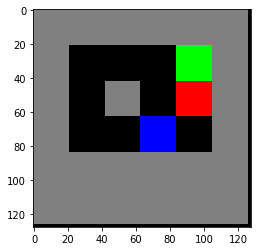

  (West)
      
      
      
      
      
      
Nombre d'etats :  11
[[1, 1, 1, 1, 1, 1], [1, 0, 0, 0, 3, 1], [1, 0, 1, 0, 5, 1], [1, 0, 0, 0, 2, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]
{0: [(0.8, '[[1, 1, 1, 1, 1, 1], [1, 0, 0, 0, 3, 1], [1, 0, 1, 0, 5, 1], [1, 0, 0, 0, 2, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]', 0, False), (0.1, '[[1, 1, 1, 1, 1, 1], [1, 0, 0, 0, 3, 1], [1, 0, 1, 0, 5, 1], [1, 0, 0, 0, 2, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]', 0, False), (0.1, '[[1, 1, 1, 1, 1, 1], [1, 0, 0, 0, 3, 1], [1, 0, 1, 0, 5, 1], [1, 0, 0, 2, 0, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]', 0, False)], 1: [(0.8, '[[1, 1, 1, 1, 1, 1], [1, 0, 0, 0, 3, 1], [1, 0, 1, 0, 2, 1], [1, 0, 0, 0, 0, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]', -1, True), (0.1, '[[1, 1, 1, 1, 1, 1], [1, 0, 0, 0, 3, 1], [1, 0, 1, 0, 5, 1], [1, 0, 0, 0, 2, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]', 0, False), (0.1, '[[1, 1, 1, 1, 1, 1], [1, 0, 0, 0, 3, 1], [1, 0, 1, 0, 5, 1], [1, 0, 0, 2, 0, 1], [1, 

In [ ]:
env = gym.make("gridworld-v0")
env.seed(0)  # Initialise le seed du pseudo-random
print(env.action_space)  # Quelles sont les actions possibles
print(env.step(1))  # faire action 1 et retourne l'observation, le reward, et un done un booleen (jeu fini ou pas)
env.render()  # permet de visualiser la grille du jeu 
env.render(mode="human") #visualisation sur la console
statedic, mdp = env.getMDP()  # recupere le mdp : statedic
print("Nombre d'etats : ",len(statedic))  # nombre d'etats ,statedic : etat-> numero de l'etat
state, transitions = list(mdp.items())[0]
print(state)  # un etat du mdp
print(transitions)  # dictionnaire des transitions pour l'etat :  {action-> [proba,etat,reward,done]}


In [ ]:
# Execution avec un Agent
#agent = RandomAgent(env.action_space)

# Faire un fichier de log sur plusieurs scenarios
outdir = 'gridworld-v0/random-agent-results'
envm = wrappers.Monitor(env, directory=outdir, force=True)#, video_callable=False)

env.setPlan("gridworldPlans/plan4.txt", {0: -0.001, 3: 1, 4: 1, 5: -1, 6: -1})
env.seed()  # Initialiser le pseudo aleatoire
episode_count = 10000
reward = 0
done = False
rsum = 0
FPS = 0.0001

In [ ]:
#env.setPlan("gridworldPlans/plan4.txt", {0: -0.001, 3: 1, 4: 1, 5: -1, 6: -1})
#env.render()
env._make("gridworldPlans/plan4.txt",{0: -0.001, 3: 1, 4: 1, 5: -1, 6: -1})
statedic, _ = env.getMDP()

In [ ]:
env.reset()
env.render()

In [ ]:
#qlAgent=QlearningAgent(env.states,env.action_space,lr=0.1,gamma=.9,eps=0.4)
#rqAgent=[]
episode_count = 10000
for i in range(episode_count):
  obs=env.reset()
  j = 0
  rsum = 0
  
  while True:
    #action = polIterAgent.act(obs)#, reward, done)
    st0=obs.copy()
    action=qlAgent.act(obs)
    obs, reward, done, _ = env.step(action)

    qlAgent.updateQvals(st0,obs,action,reward,done)
    
    rsum += reward
    j += 1
    if done:
      rqAgent.append(rsum)
      if i%100==0:
        print("Episode : " + str(i) + " rsum=" + str(rsum) + ", " + str(j) + " actions")
        
      break
    
print("done")
env.close()

In [ ]:

plt.plot(np.cumsum(rqAgent))
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")

In [ ]:
episode_count=100000
sarsaAgnt=SARSAAgent(env.states,env.action_space,lr=0.1,gamma=.9,eps=0.4)
rSarsAgent=[]
for i in range(episode_count):
  
  obs0=env.reset()
  

  j = 0
  rsum = 0
  
  while True:
    #action = polIterAgent.act(obs)#, reward, done)
    #st0=obs.copy()

    obsx=obs0.copy()

    action1=sarsaAgnt.act(obs0)
    obs1, reward, done, _ = env.step(action1)


    action2=sarsaAgnt.act(obs1)

    sarsaAgnt.updateQvals(obsx,obs1,action1,action2,reward,done)
    obs0=obs1.copy()
    
    rsum += reward
    j += 1
    if done:
      rSarsAgent.append(rsum)
      if i%500==0:
        print("Episode : " + str(i) + " rsum=" + str(rsum) + ", " + str(j) + " actions")
      break
    
print("done")
env.close()

Text(0, 0.5, 'Cumulative reward')

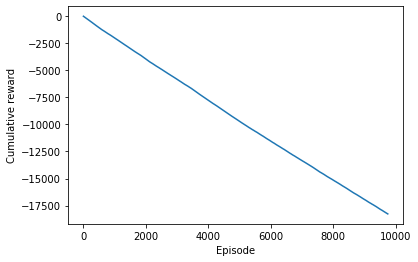

In [ ]:
plt.plot(np.cumsum(rSarsAgent))
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")

In [ ]:

episode_count=1000
terminStates=list(set(env.states.keys()).difference(set(mdp.keys())))
dynQAgnt=DynaQAgent(env.states,env.action_space,terminStates,lr=0.1,gamma=.9,eps=0.4,k=100,alphaUpdate=.4)
rDyna=[]
for i in range(episode_count):
  obs=env.reset()
  j = 0
  rsum = 0
  
  while True:
    #action = polIterAgent.act(obs)#, reward, done)
    st0=obs.copy()
    action=dynQAgnt.act(obs)
    obs, reward, done, _ = env.step(action)

    dynQAgnt.updateQvals(st0,obs,action,reward,done)
    
    rsum += reward
    j += 1
    if done:
      rDyna.append(rsum)
      if i%100==0:
        print("Episode : " + str(i) + " rsum=" + str(rsum) + ", " + str(j) + " actions")
      break
    
print("done")
env.close()

Text(0, 0.5, 'Cumulative reward')

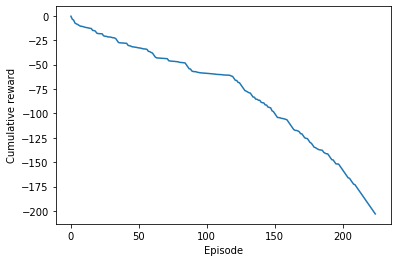

In [ ]:

plt.plot(np.cumsum(rDyna))
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")